# ML 2-class Classification 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbe95cbfc40>

MLfit applied to 4FGL-DR4 

Scikit-learn specifications: 
* features: log_var, log_fpeak, log_epeak, d
* classes: pulsar, blazar
* model: SVC(C=1, gamma=2)
        

## Feature distributions 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbeadd50a00>
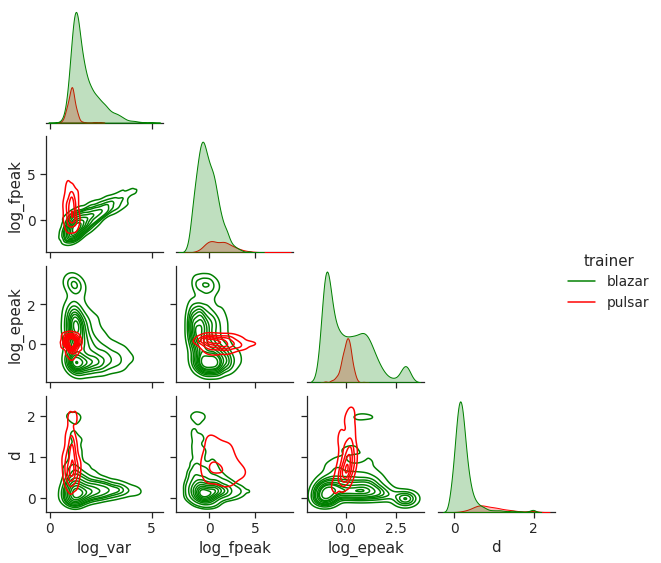

## Train then apply prediction 

### Precision-recall graph
These evaluations shows how well the pulsars are distinguished from blazars.
Comparison of our SVC model with the neural network alternative.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbeadb6b9d0>
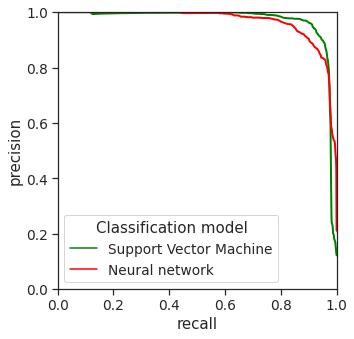

### All predictions

prediction,blazar,pulsar
association,,
bll,1471,4
fsrq,805,3
psr,5,135
msp,11,165
glc,12,22
spp,37,68
snr,18,23
rdg,48,2
other,60,21


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbeaec2c040>
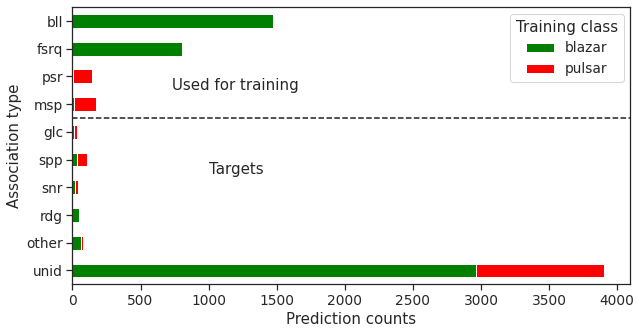

## The issue with this
In figure 1.4 we show the pulsar probability distributions for the training classes, and
the unid target. The large number of unid sources not near 0 or 1 demonstrates the 
existence of a component not in the training set, violating the basic ML assumption.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fbeaebd3610>
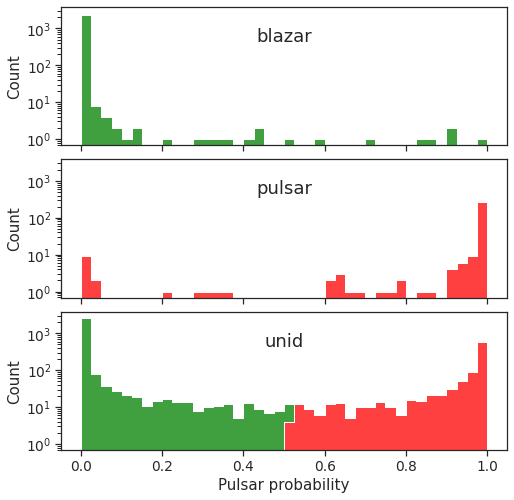

File `files/dr4_2_class_classification.csv` exists--not overwriting.


In [5]:
%run pylib/ml_fit show
sns.set_style('ticks')
self=doc(2);
plt.close()


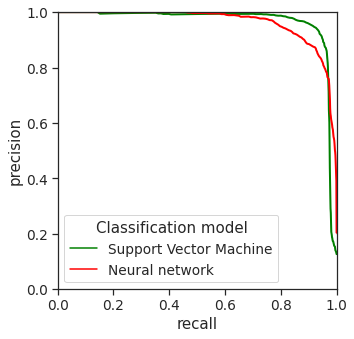

In [12]:
fig = self.precision_recall(dict(SVC='Support Vector Machine', NN='Neural network'))
fig.savefig('figures/fig-3.png', facecolor='w', bbox_inches='tight')

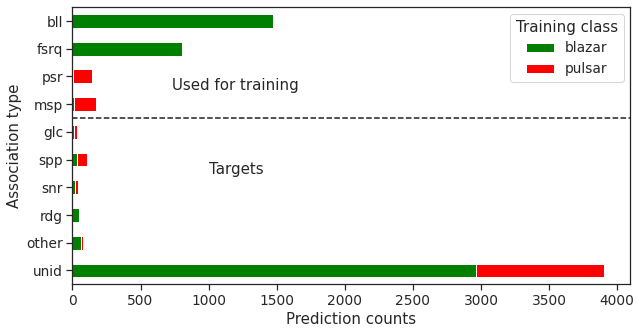

In [6]:
fig = self.plot_prediction_association(
    self.prediction_association_table())
fig.savefig('figures/fig-4.png', facecolor='w')

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f70b20ac5b0>
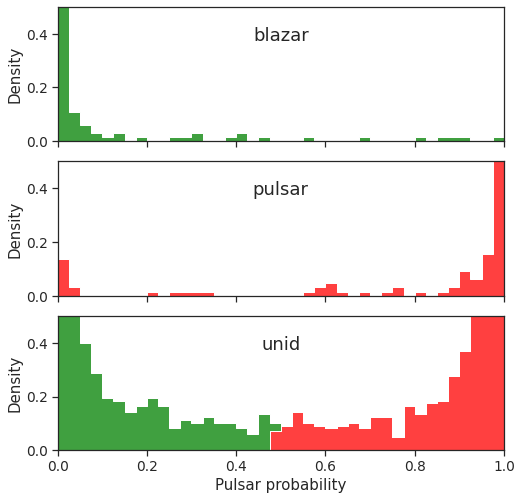

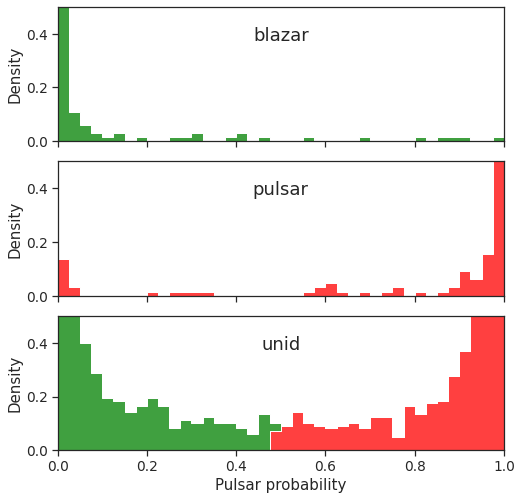

In [9]:

def pulsar_prob_hists(self, stat='density', xlim=(0,1), ylim=None):
    """Histograms of the classifier pulsar probability. 
    Upper two plots: each of the labeled training classes; lower plot: histogram
    for the classifier assignments, colors corresponding to the plots above.
    """
    probs= self.predict_prob(query=None)
    df = pd.concat([self.df, probs], axis=1)

    non_trainers = ['unid'] #, 'bcu'] 
    titles = list(self.trainer_names) + non_trainers
    fig, axx = plt.subplots(nrows=len(titles), figsize=(8,8),sharex=True, sharey=True,
                                gridspec_kw=dict(hspace=0.15))
    kw = dict( x='p_pulsar',  bins=np.arange(0,1.01, 0.025), # log_scale=(False,True),
              stat=stat,
                element='step', multiple='stack', legend=False)

    for ax, hue_order, color in zip(axx, self.trainer_names, self.palette):        
        sns.histplot(df, ax=ax,  hue='trainer',hue_order=[hue_order],
                    palette=[color],**kw)            

    for i,nt in enumerate(non_trainers):
        ntr = len(self.trainers)
        sns.histplot(df.query(f'association=="{nt}"'), ax=axx[i+ntr], hue='prediction', 
                hue_order=self.trainer_names,  palette=self.palette[:ntr],**kw);
    
    axx[-1].set(xlabel='Pulsar probability', xlim=xlim, ylim=ylim)
    for ax, title in zip(axx, titles):
        ax.text( 0.5, 0.75, title, ha='center', transform=ax.transAxes, fontsize='large')
    return fig
sns.set_style('ticks')
fig = pulsar_prob_hists( self, 'density', (0.,1), (0,.5))
fig.savefig('figures/fig-5.png', facecolor='w')
                        
show_fig(pulsar_prob_hists, self, 'density', (0.,1), (0,.5)) #'density')

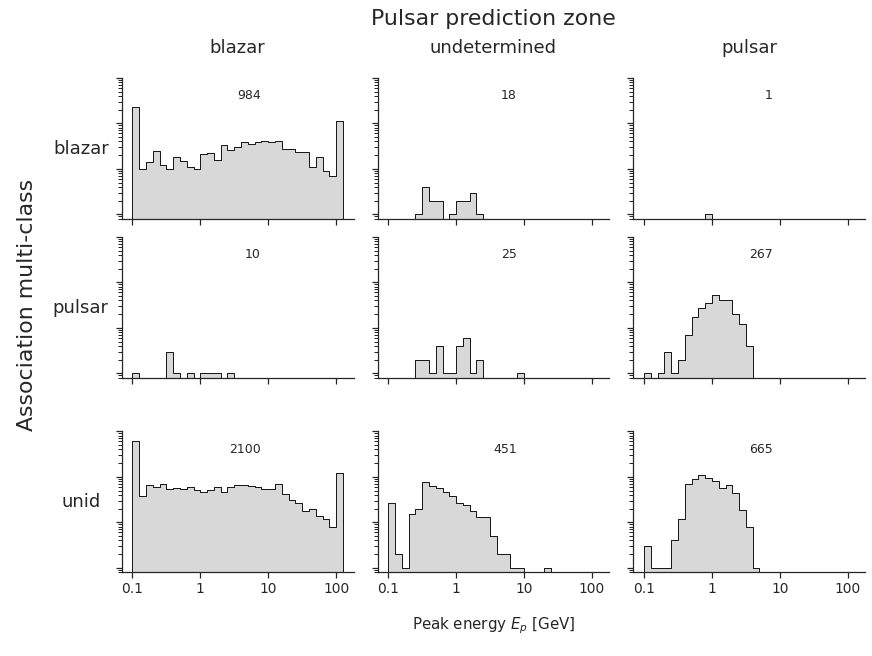

In [17]:
def zone_vs_class(self, query='variability<25', *, zone_def=[0.1,0.95], 
                  var_name='log_epeak', bins=np.arange(-1,2.2,0.1)):
    """Table of histograms of the {var_name} with pulsar prediction zone columns 
    and association class rows. The number of sources are shown on the histogram plots, which are log-log scale.
    The energy bin above 100 GeV contains all entries above that. The vertical scale shows three decades to 1000.
    """
    # append columns with predection probability
    probs = self.predict_prob(query=None)
    dfc = pd.concat([self.df, probs], axis=1).copy()
    if query is not None:
         df=dfc.query(query).copy()
    else:
        df = dfc.copy()
    df.log_epeak = df.log_epeak.clip(-1,2)

    # set zone, class name, make a 2-d group
    df['zone'] = np.digitize(df.p_pulsar, zone_def)
    zone_names = 'blazar undetermined pulsar'.split()
    
    def set_class(x):
        if x in 'bll fsrq'.split(): return 'blazar'
        if x =='unid': return x
        if x in 'psr msp'.split(): return 'pulsar' 
        return np.nan
    df['class_name'] = df.association.apply(set_class)
    class_names = 'blazar pulsar unid'.split()
    
    g = df.groupby(['class_name','zone'])
    
    fig = plt.figure(figsize=(12,9), layout="constrained")
    axd = fig.subplot_mosaic(
                  [ ['.', '.',  't',    't',  't'  ],
                    ['s', '.',  'z0',   'z1', 'z2' ],
                    ['s', 'c0', 'h00', 'h01', 'h02'],
                    ['s', 'c1', 'h10', 'h11', 'h12'],
                    ['s',  '.', '.',    '.',  '.'  ],                   
                    ['s', 'c2', 'h20', 'h21', 'h22'],
                    ['.', '.',  'b',   'b',   'b'  ], ],
            width_ratios = [0.5,0.75,3,3,3], 
            height_ratios=[0.5,0.5,3,3,0.5,3,1], )

    def make_label(ax,text, fontsize='large',  **kwargs):
        ax.text(0.5,0.5, text, ha='center', va='center', fontsize=fontsize,  **kwargs)
        ax.set_axis_off()
        
    for label, ax in axd.items():
        if label=='t':  make_label(ax, 'Pulsar prediction zone',fontsize=22); continue
        if label=='s':  make_label(ax, 'Association multi-class', rotation='vertical',fontsize=22); continue
        if label=='b':  make_label(ax, 'Peak energy $E_p$ [GeV]' if var_name=='log_epeak' else var_name, fontsize=None,); continue
        if label[0]=='z': make_label(ax, zone_names[int(label[1])]); continue;
        if label[0]=='c': make_label(ax, class_names[int(label[1])]); continue;
    
        c,z = int(label[1]), int(label[2])
        try:
            cdf = g.get_group((class_names[c], z))
            sns.histplot( ax=ax, x=cdf[var_name], log_scale=(False, True), element='step', 
              color='0.8', bins=bins, edgecolor='k' )
        except KeyError: #if empty
            cdf = []
        ax.set(xlabel='', ylabel='', yticklabels=[], # xlim=(-1,2.1),
               ylim=(0.8,1e3))
        if  var_name=='log_epeak':
            ax.set(xticks=[-1,0,1,2], xticklabels=[] if c<2 else '0.1 1 10 100'.split())
        elif c<2:
            ax.set(xticklabels=[])
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.text(0.6,0.85, f'{len(cdf)}', transform=ax.transAxes, ha='right', fontsize='small')
    return fig
fig = zone_vs_class( self,  var_name='log_epeak') #, format_kw=(dict(var_name='peak energy')))
fig.savefig('figures/fig-6.png', facecolor='w', bbox_inches='tight')
     
# show_fig( zone_vs_class, self,  var_name='log_epeak', format_kw=(dict(var_name='peak energy')))

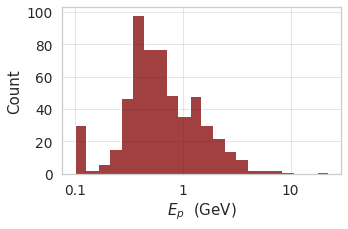

In [4]:
def unid_undet(self, query='variability<25', *, zone_def=[0.1,0.95], 
                  var_name='log_epeak', bins=np.arange(-1,2.2,0.1)):

    # append columns with predection probability|
    probs = self.predict_prob(query=None)
    dfc = pd.concat([self.df, probs], axis=1).copy()
    if query is not None:
         df=dfc.query(query).copy()
    else:
        df = dfc.copy()
    df.log_epeak = df.log_epeak.clip(-1,2)

    # set zone, class name, make a 2-d group
    df['zone'] = np.digitize(df.p_pulsar, zone_def)
    return df
df = unid_undet(self).query('zone==1')
ax = sns.histplot(df, x='log_epeak', element='step', color='maroon', edgecolor='w');
ax.set(**epeak_kw());

In [5]:
def get_diffuse(df):
    from astropy.coordinates import SkyCoord
    from pylib.diffuse import Diffuse
    diff = Diffuse()
    sdirs = SkyCoord(df.glon, df.glat, unit='deg', frame='galactic')
    return  diff.get_values_at(sdirs)
if 'diffuse' not in self.df.columns:
    self.df['diffuse'] = get_diffuse(self.df)

* Load diffuse file,  `/mnt/c/users/thbur/OneDrive/fermi/diffuse/gll_iem_v07_hpx.fits`
  unit=$\rm{eV\ cm^{-2}\ s^{-1}\ deg^{-2}}$
 select energy= 1000 MeV


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f70d80a6c80>
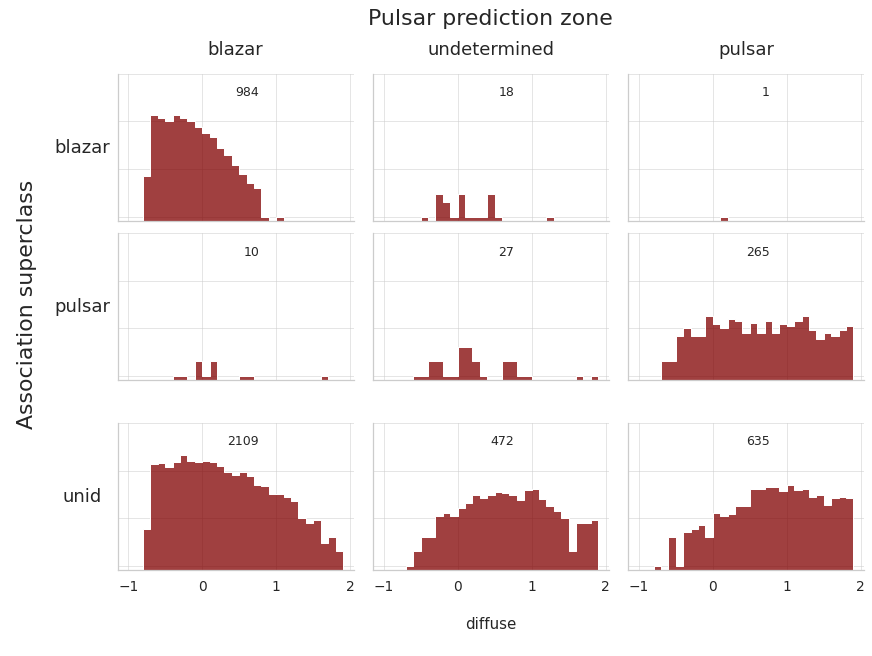

In [6]:
show_fig(zone_vs_class, self, var_name='diffuse', bins=np.arange(-1,2,0.1), format_kw=dict(var_name='diffuse correlation parameter'))

## Feature variable correlations

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f70b175c7f0>
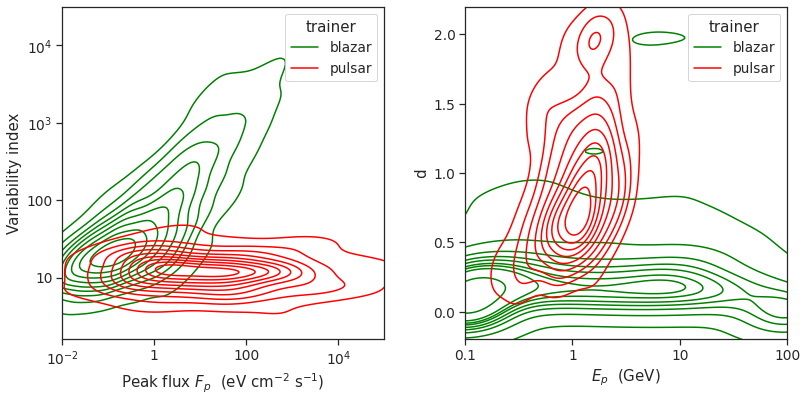

In [19]:
%run pylib/tools
show("""## Feature variable correlations""")

fig, (ax2,ax1) = plt.subplots(ncols=2, figsize=(13,6), 
                             gridspec_kw=dict(wspace=0.25))
dfq= self.df #dfc
sns.kdeplot(dfq, ax=ax1,  x=dfq.log_epeak.clip(-1,2), hue='trainer',
                y='d', palette = self.palette[:2], common_norm=False,
           clip=((-1,2),(-0.2,2.2)));
ax1.set(**epeak_kw(show_100=True), yticks=np.arange(0,2.1,0.5),)


sns.kdeplot(dfq, ax=ax2,  x='log_fpeak', hue='trainer',
                y='log_var', palette = self.palette[:2], common_norm=False,  );
ax2.set(**fpeak_kw(), **var_kw('y'), ylim=(0.2,4.5))
show(fig)
fig.savefig('figures/fig-2.png', facecolor='w')

In [15]:
self.df

,glat,glon,significance,r95,variability,class1,association,Ep,Fp,d,d_unc,hasdr3,sqrt_d,log_var,log_epeak,log_fpeak,trainer,prediction,diffuse
4FGL-DR4,,,,,,,,,,,,,,,,,,,
4FGL J0000.3-7355,-42.729538,307.708984,8.492646,0.0525,12.834996,,unid,1.647642,0.014569,0.183915,0.277791,True,0.428853,1.108396,0.216863,-1.836564,NaN,blazar,-0.324147
4FGL J0000.5+0743,-53.029457,101.656479,5.681097,0.1533,25.568989,,unid,1.208057,0.048514,0.908976,0.579221,True,0.953402,1.407714,0.082088,-1.314134,NaN,blazar,-0.293747
4FGL J0000.7+2530,-35.959175,108.775070,4.197268,0.0833,13.149277,,unid,10.111068,0.009454,0.752790,0.740615,True,0.867634,1.118902,1.004797,-2.024393,NaN,blazar,-0.359128
4FGL J0001.2+4741,-14.338059,114.250198,5.523873,0.0598,28.915590,bcu,unid,0.100000,0.043246,0.024318,0.217760,True,0.155944,1.461132,-1.000000,-1.364057,NaN,blazar,0.082370
4FGL J0001.2-0747,-67.305008,89.032722,24.497219,0.0299,51.742390,bll,bll,0.796298,0.723029,0.102386,0.067469,True,0.319978,1.713846,-0.098924,-0.140844,blazar,blazar,-0.463753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4FGL J2359.3-2049,-76.542862,58.090145,18.289204,0.0399,14.498226,bll,bll,347.829117,0.098137,0.003522,0.076661,True,0.059343,1.161315,2.541366,-1.008168,blazar,blazar,-0.651597
4FGL J2359.3+1444,-46.256252,104.564713,7.791155,0.2217,13.562005,,unid,0.375964,0.176734,0.644601,0.401554,True,0.802870,1.132324,-0.424854,-0.752680,NaN,blazar,-0.357350
4FGL J2359.7-5041,-64.472755,322.128052,5.150436,0.2119,6.934350,bcu,unid,0.560016,0.041555,1.462564,0.928811,True,1.209365,0.841006,-0.251800,-1.381377,NaN,blazar,-0.610060


In [ ]:
show("""### Pulsar predictions""")
(sns.ecdfplot(dfc.query('prediction=="pulsar"'), x='variability', )
     .set(xlim=(15,30), ylim=(0.9,1))
);

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))
# dfq = dfc.query('subset=="pulsar"')
# sns.scatterplot(dfq,ax=ax,  x=dfq.log_epeak.clip(-1,2), hue='pulsar zone', s=10, y='d', palette = self.palette );
# show(fig)

In [ ]:
show(f"""## Look at $F_p$ vs. $E_p$""")
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(dfq.query('d>0.5') ,ax=ax, 
                x=dfq.log_epeak.clip(-1,2), hue='pulsar zone',
                s=10, y='log_fpeak', palette = self.palette );
show(fig)

In [ ]:
def fpeak_kw(axis='x'):
    return {axis+'label':r'Peak flux $F_p\ \ \mathrm{ (eV\ cm^{-2}\ s^{-1})}$', 
            axis+'ticks': np.arange(-2,4.9,2),
            axis+'ticklabels': '$10^{-2}$ 1 100 $10^4$'.split(),
            axis+'lim': (-2.5,4.5 ),
            }
show(f"""## Study $F_p$ vs diffuse for blazars
Select "{(cut:="variability<25 & 0.15<Ep<4 & d>0.2")}" """)
# fig, ax = plt.subplots(figsize=(15,6))
data = self.df.query(cut);# print(len(data))

jnt = sns.jointplot(data, x='diffuse', y=data.log_fpeak.clip(-2.5,3), height=8, #.clip(-3,3), 
                hue='association', hue_order='fsrq bll bcu'.split(), palette=self.palette, edgecolor='none',
);
from matplotlib import ticker as mticker
ax = jnt.ax_joint
ax.set(**diffuse_kw(), ** fpeak_kw('y'))
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs='auto'))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs='auto'))
show(jnt.figure)

In [ ]:
show(f"""## Compare pulsars and unids:
### $F_p$ vs diffuse  """)

jnt = sns.jointplot(data, x='diffuse', y=data.log_fpeak.clip(-2.5,4.5), height=8, #.clip(-3,3), 
                hue='association', hue_order='psr msp'.split(), palette=self.palette[:2], edgecolor='none',
);
jnt.ax_joint.set(**diffuse_kw(), ** fpeak_kw('y'))
sns.kdeplot(data.query('association=="unid"'), ax=jnt.ax_joint, x='diffuse', y='log_fpeak', color='0.5' )
show(jnt.figure)
show(f"""### $E_p$ vs diffuse""")

jnt = sns.jointplot(data, x='diffuse', y=data.log_epeak.clip(-2.5,4.5), height=8, #.clip(-3,3), 
                hue='association', hue_order='psr msp'.split(), palette=self.palette[:2], edgecolor='none',
);
jnt.ax_joint.set(**diffuse_kw(), ** epeak_kw('y'))
sns.kdeplot(data.query('association=="unid"'), ax=jnt.ax_joint, x='diffuse', y='log_epeak', color='0.5' )
show(jnt.figure)

In [ ]:
if 'fgl' not in globals(): fgl = Fermi4FGL()
show(f"""### Check counterpart catalogs used for {(cat:="bcu")}""")
agn = self.df.query(f'association=="{cat}"').copy()# & diffuse>0.5'); 
show(f'Totsl: {len(agn)}')
anames = fgl.loc[agn.index].assoc1_name
cn  = list(map(lambda x: x.split()[0], anames))
t = np.unique(cn, return_counts=True)
# pd.DataFrame.from_dict( 
show(pd.Series(dict( (a,b) for a,b in zip(t[0], t[1]))))
# for n in list(filter(lambda x: x.startswith("NVSS"), anames)): print(n)

In [ ]:
show(f"""### NVSS content of blazar classes""")
tdf = fgl.copy()
tdf['acatname'] = tdf.assoc1_name.apply(lambda x: x if pd.isna(x) or len(x)==0 else x.split()[0])
u = tdf.groupby('acatname').size()
# bll.query('acatname=="NVSS"')
bins = np.arange(-1,2, 0.1)
fig, axx = plt.subplots(nrows=3, figsize=(8,12), sharex=True, 
                       gridspec_kw=dict(hspace=0.05))
for agn_name, ax in zip('fsrq bll bcu'.split(), axx.flat):
    ax.text(0.5, 0.9, f"""{agn_name}""", transform=ax.transAxes, ha='center', fontsize='large')
    agn = self.df.query(f'association=="{agn_name}"').copy()
    agn['assoc1_name'] = tdf.loc[np.isin(tdf.index, agn.index), 'assoc1_name']
    agn['acatname'] = agn.assoc1_name.apply(lambda x: x if pd.isna(x) or len(x)==0 else x.split()[0])

    sns.histplot(agn, ax=ax, x='diffuse', bins=bins,  element='step', label=f'all-{len(agn)} ');
    nvss = agn.query('acatname=="NVSS"')
    sns.histplot(nvss, ax=ax, x='diffuse', bins=bins, element='step', color='maroon', edgecolor='w',label=f'NVSS-{len(nvss)}');
    ax.set(**diffuse_kw())
    ax.legend();
show(fig)

In [ ]:
def pulsar_prob_hists(self, query=None):
    """Histograms of the classifier pulsar probability. 
    Upper three plots: each of the labeled training classes; lower plots: stacked histograms
    for the classifier assignments, colors corresponding to the plots above.
    """
    # append probabilities for all sources
    probs= self.predict_prob(query=None)
    df = pd.concat([self.df, probs], axis=1)
    if query is not None: df = df.query(query)
    
    non_trainers = ['unid', 'bcu']
    titles = list(self.trainer_names) + non_trainers
    
    fig, axx = plt.subplots(nrows=len(titles), figsize=(8,10),sharex=True, sharey=True,
                                gridspec_kw=dict(hspace=0.05))
    kw = dict( x='p_pulsar',  bins=np.arange(0,1.01, 0.025), log_scale=(False,True),
                element='step', multiple='stack', legend=False)

    for ax, hue_order, color in zip(axx, self.trainer_names, self.palette):        
        sns.histplot(df, ax=ax,  hue='trainer',hue_order=[hue_order],
                    palette=[color],**kw)            

    for i,nt in enumerate(non_trainers):
        sns.histplot(df.query(f'association=="{nt}"'), ax=axx[i+3], hue='prediction', 
                hue_order=self.trainer_names,  palette=self.palette,**kw);
    
    axx[-1].set(xlabel='Pulsar probability')
    for ax, title in zip(axx, titles):
        ax.text( 0.5, 0.75, title, ha='center', transform=ax.transAxes, fontsize='large')
    return fig
show_fig(pulsar_prob_hists, self, 'Ep>4')

In [ ]:
show_fig(pulsar_prob_hists, self,)

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))
# sns.scatterplot(df, ax=ax, x='log_epeak', y='p_pulsar', hue='association', 
#                 hue_order=list(self.trainer_names) + ['unid', 'bcu'], s=10, edgecolor='none' );
# ax.set(**epeak_kw(show_100=True));
# show(fig)

# show("""### unid zones""")
# hkw = dict(x='log_epeak', element='step', bins=50, log_scale=(False, True))
# fig, ax = plt.subplots(figsize=(10,3))
# sns.kdeplot(df.query('association=="unid"'),ax=ax, hue='zone', palette=self.palette,x='log_epeak')
# ax.set(**epeak_kw(show_100=True), xlim=(-1,2));# **hkw);

# (sns.FacetGrid(df, col='zone', row='class', row_order='bll fsrq pulsar unid bcu'.split(), aspect=2, height=2)
#  .map(sns.histplot, 'log_epeak',log_scale=(False, True), element='step', 
#       color='lightblue', bins=np.arange(-1,2.2,0.1), edgecolor='w' )
#  .set(title='', ylabel='', yticklabels=[] )
# );

In [ ]:
show("""#### What are the "others"?""")
def make_other(s):
    if s in 'bll fsrq psr msp bcu spp snr rdg glc unid'.split():
        return s
    return 'other'
dft =self.df.copy()
dft.loc[:,'ass'] = dft.association.apply(make_other).values

show(pd.Series(
    dft.query('ass=="other"').groupby('association').size(),
    name='"Other"  contents'))


In [ ]:
show("""---
# Extra items""") 

In [ ]:
df3 = pd.read_csv(f'files/dr4_3_class_classification.csv', index_col=0)
self.df['diffuse'] = df3.diffuse

In [ ]:
def ep_vs_d(self, df=None):
    # from pylib.tools import epeak_kw
    if df is None: df=self.df
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5),sharex=True,sharey=True,
                                gridspec_kw=dict(wspace=0.05))
    kw = dict( x='log_epeak', y='d',  palette=self.palette[:len(self.trainers)],
              clip=((-1,1),(0.2,2)),
              hue_order=self.trainer_names)
    
    sns.kdeplot(df,ax=ax1, hue=self.trainer_field, **kw)
    sns.kdeplot(df.query('association=="unid"'),ax=ax2, hue='prediction',**kw)

    ax1.set(**epeak_kw(),ylabel='curvature $d$', xlim=(-1.5,1.5)); ax2.set(**epeak_kw())
    return fig
show(f"""---
## Compare $E_p$ vs $d$ for training and unid prediction""")
show_fig(ep_vs_d, self)

In [ ]:
    def fp_vs_d(self, df=None):
        from pylib.tools import fpeak_kw
        if df is None: df=self.df
        fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5),sharex=True,sharey=True,
                                    gridspec_kw=dict(wspace=0.05))
        kw = dict( x='log_fpeak', y='d',  palette=self.palette[:len(self.trainers)],
                  hue_order=self.trainer_names)
        
        sns.kdeplot(df,ax=ax1, hue=self.trainer_field, **kw)
        sns.kdeplot(df.query('association=="unid"'),ax=ax2, hue='prediction',**kw)

        ax1.set(**fpeak_kw(),ylabel='curvature $d$'); ax2.set(**fpeak_kw())
        return fig
    fp_vs_d(self);

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

self.precision_recall(ax=ax);

show(fig)
# from sklearn.metrics import PrecisionRecallDisplay
# PrecisionRecallDisplay.from_estimator

In [ ]:
show_fig(self.pulsar_prob_hists, )

In [ ]:
probs= self.predict_prob(query=None)
df = pd.concat([self.df, probs], axis=1)
d = {}
for non_target in ['unid','bcu', 'bll', 'fsrq', 'msp', 'psr']:
    unid = df.query(f'association=="{non_target}"').copy()
    d[non_target] = {'Total'     : len(unid),
         'predicted pulsar' : len(unid.query('prediction=="pulsar"')),
         'Likely blazar'    : len(unid.query('p_pulsar<0.15')),
         'Mystery'          : len(unid.query('0.95>p_pulsar>0.15')),
         'Mostly pulsars'   : len(unid.query('p_pulsar>0.95')),
        }
show(pd.DataFrame(d))

In [ ]:
def pulsar_like(p):
    if p < 0.1: return 0
    if p < 0.95: return 1
    return 2
unid['pulsar_like'] = unid.p_pulsar.apply(pulsar_like)
sns.kdeplot(unid, x='log_epeak', y='d', hue='pulsar_like', palette=self.palette)


In [ ]:
ax=sns.kdeplot(unid.query('0.95>p_pulsar>0.1'), color='cyan', x='log_epeak', y='d');
ax.set(**epeak_kw(), yticks=np.arange(0,2.1,0.5));
show(f"""### Mystery""")
show(ax.figure)

In [ ]:
show("""### Featues for unid's""")
show_fig(self.pairplot, query='association=="unid"', hue='prediction');

In [ ]:
sns.ecdfplot(self.df.query('association=="unid"'), x='variability')\
    .set(xlim=(0,50), ylim=(0.5,1));#, element='step', bins=np.arange(0,40,1));

In [ ]:
bcu = df.query('association=="bcu"')
show(bcu.groupby('prediction').size())
z = np.abs( np.abs(np.sin(np.radians(bcu.glat) )))
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(bcu, ax=ax, x=z, hue='prediction', palette=self.palette, 
             bins=np.arange(0,1.01,0.05), element='step', multiple='stack');
ax.set(xlabel=r'$|\sin(b)|$', title="Galactic latitude for bcu's") ;          

In [ ]:
show("""---
## Confusion""")

In [ ]:
cmdf = self.confusion_matrix()
show(cmdf)

In [ ]:
show(f"""---
## Effect of the specisl selection
  "{(cut:='0.15<Ep<1 & d>0.2 & variability<25 & 0.2<diffuse<1.2')}"
""")
dfall = self.df.copy()
tall = self.prediction_association_table(dfall)
dfcut = self.df.copy().query(cut)
tsub=self.prediction_association_table(dfcut);
fig, (ax1,ax2) = plt.subplots(layout='constrained', nrows=2, figsize=(8,7), sharex=True,
                             gridspec_kw=dict(hspace=0.075))
self.plot_prediction_association(table = tall, ax=ax1);
ax1.text(-0.2,1.1, 'Before',  ha='left', fontsize=24, transform=ax1.transAxes)
self.plot_prediction_association(table = tsub, ax=ax2);
ax2.text(-.2,1.1, f'After', ha='left', fontsize=24, transform=ax2.transAxes)
ax2.set_title(cut, fontsize='small')
show(fig)

show(pd.DataFrame([
    pd.Series(dfall.groupby('association').size(),name='before'),
    pd.Series(dfcut.groupby('association').size(),name='after')]))

In [ ]:
dfcut.query('association=="bcu"').hist('significance diffuse d Ep Fp'.split(), bins=25);

In [ ]:
for n in dfcut.index: print(n)